# Minalyze: Geochemistry

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('../data/OOLDEA2_1m_intervals.csv')

In [ ]:
df.tail()

In [ ]:
df.columns

In [ ]:
var_str = list( df.columns )

features = (
    [i for i, s in enumerate(var_str) if "pct" in s 
        and "mdl" not in s 
        and "2SE" not in s] + 
    [i for i, s in enumerate(var_str) if "ppm"  in s 
        and "mdl" not in s 
        and "2SE" not in s]
        )

df_features = df.iloc[:,features[1:]]

df_features.head()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#pca = PCA(n_components = 3)
#X = pca.fit_transform(df_features)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=10))])
X=pipeline.fit_transform(df_features)

In [ ]:
def plot_pca(X, mode="2D"):

    if mode.lower() == "2d":

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, aspect='equal')

        ax.scatter(X[:, 0], X[:, 1], alpha=.5, s=60)

        ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
        ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
        ax.set_xlabel("$pca_1$", fontsize=18)
        ax.set_ylabel("$pca_2$", fontsize=18)
        ax.grid(True)

    elif mode.lower() == "3d":

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(X[:, 0], X[:, 1],  X[:, 2],  alpha=.4, s=60)
        ax.view_init(25, -50)

        ax.set_xlabel("$pca_1$", fontsize=18)
        ax.set_ylabel("$pca_2$", fontsize=18)
        ax.set_zlabel("$pca_3$", fontsize=18)
        ax.grid(True)

    else:

        print('Unknown mode: please specify as 2D or 3D')


In [ ]:
plot_pca( X )

In [ ]:
plot_pca( X, mode="3D")

## K-Means

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
                
inertias = [model.inertia_ for model in kmeans_per_k]

In [ ]:
def  elbow_plot(inertias):
    plt.figure(figsize=(8, 3.5))
    plt.plot(range(1, len(inertias)+1), inertias, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Inertia", fontsize=14)
    plt.annotate('Elbow',
                xy=(3, inertias[2]),
                xytext=(0.55, 0.55),
                textcoords='figure fraction',
                fontsize=16,
                arrowprops=dict(facecolor='black', shrink=0.1)
                )

In [ ]:
elbow_plot(inertias)

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for iter in range(3):
    ax.scatter(X[y_pred == iter, 0], X[y_pred == iter, 1],  X[y_pred == iter, 2], alpha=.4, s=60)

ax.view_init(25, -50)

ax.set_xlabel("$pca_1$", fontsize=18)
ax.set_ylabel("$pca_2$", fontsize=18)
ax.set_zlabel("$pca_3$", fontsize=18)
ax.grid(True)


## Hierarchical clustering

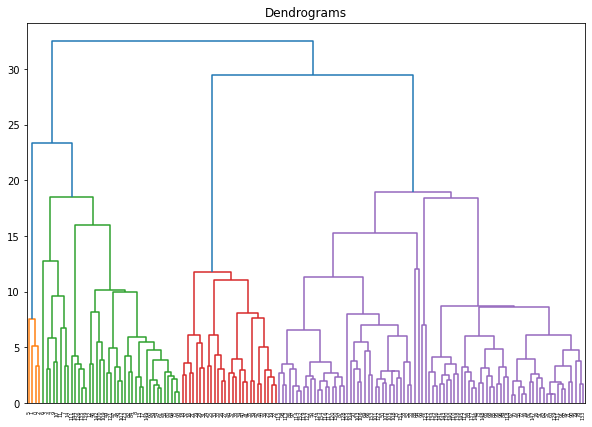

In [32]:
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize 

#X = sklearn.preprocessing.normalize(df_features)

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms") 
dendro = shc.dendrogram(shc.linkage(X, method='ward'))

In [35]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', 
    linkage='ward', compute_full_tree=True, distance_threshold=20)  
lbl = cluster.fit_predict(X)

n = 1+np.amax(cluster.labels_)

print(f"Number of clusters = {n}")


Number of clusters = 4


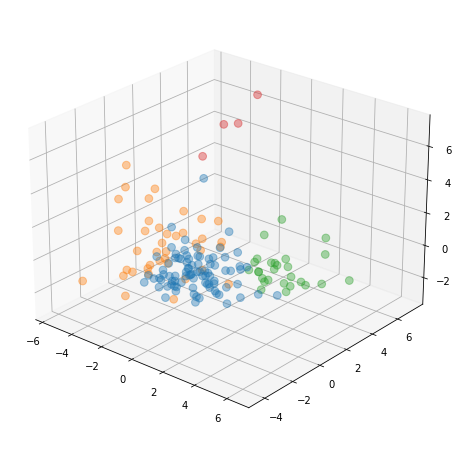

In [36]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for iter in range(n):
    ax.scatter(X[lbl == iter, 0], X[lbl == iter, 1],  X[lbl == iter, 2], alpha=.4, s=60)

ax.view_init(25, -50)